# Алгоритм Томпсона на батчах (без контекста)

1. На первом батче распределяем юзеров 50% на 50%.
2. Вероятность конверсии каждого варианта распределена по Beta распределению с $\alpha=1$,
$\beta=1$.
3. В конце каждого батча пересчитываем вероятности превосходства по точной формуле,
взятой отсюда https://www.johndcook.com//UTMDABTR-005-05.pdf
4. Распределяем трафик в пропорции вероятностей превосходства для каждого варианта
5. Останавливаем эксперимент при достижении определенной вероятности превосходства,
но не раньше определенного дня, чтобы учесть календарные факторы

Потенциальные проблемы:
- слишком рано отдаем трафик победителю
- из-за дисбаланса распределения трафика может быть больше успешных конверсий в этом варианте
(можно попробовать применить нормализацию)


***Реализуем алгоритм***

0. **Инициализация** - *BatchThompson(n_arms)*. Аргумент на вход: число вариантов сплита.
Здесь также инициализируются массивы для параметров Бета-распределений и вероятность превосходства = 0.5.

1. **Метод сплита** - *split_data()*. Исходя из вероятности превосходства вычисляем сплит по вариантам.
Возвращаем данные по конверсии на текущем батче для пересчета Бета-распределений.

2. **Метод изменения параметров распределения** - *.update_beta_params(data)*. Аргументы на вход: numpy массив со значениями конверсии по
каждому варианту. В случае неравномерного распределения по вариантам ставятся пропуски.
 - Проверяем, чтобы число столбцов совпадало с числом вариантов из инициализации.
 - Суммируем нули и единицы и обновляем параметры

3. **Метод пересчета** - *update_prob_super()*. Аргументов нет, так как учитывает измененные параметры
$\alpha$ (накопленное число успешных конверсий) и
$\beta$ (накопленное число неудачных конверсий) для всех вариантов.
 - Считаем по точной формуле
 - Выдаем массив из вероятностей превосходства

4. **Вероятность превосходства** - *prob_super_tuple()*. Аргументов нет, так как берем пересчитанные параметры.
5. **Критерий остановки** (*stopping_criterion*) - условия цикла while. Либо вероятность превосходства выше заданной
величины, либо закончились наблюдения.

In [1]:
from typing import List, Tuple
import os
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from numpy import ndarray
from tqdm.notebook import tqdm
from src.ab import get_size_zratio
from src.mab import calc_prob_between

# Графики
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import warnings
warnings.filterwarnings("ignore")
from src.mab import BatchThompson
from matplotlib.backends.backend_pdf import PdfPages
from joblib import Parallel, delayed

# Эксперименты на разных теоретических конверсиях и размерах батча (summation vs normalization)

In [72]:
def thompson_results(algo_class, *index):
    p1_control, mde_test_effect, batch_size_share = index
    p_list = [p1_control, p1_control * (1 + mde_test_effect)]
    bts = algo_class(p_list_mu=p_list, batch_size_share_mu=batch_size_share)
    probability_superiority_steps, observations_step_list = bts.start_experiment()
    cumulative_observations_step_list = np.cumsum(observations_step_list, axis=0)
    return probability_superiority_steps, cumulative_observations_step_list, bts.n_obs_every_arm

def plot_mab_results(directory, name, result_experiments_df):
    """
    Function creates two lines in one plot: left axis - probability superiority, right - cummulative observation
    :param p_list_mu: expectation for conversion rates
    :param batch_size_share_mu: expectation for batch size
    :param probability_superiority_steps:
    :param cumulative_observations_step_list:
    :param folder:
    :return:
    """
    plot_file = PdfPages(f"{directory}/{name}.pdf")
    for index, row in result_experiments_df.iterrows():
        p1_control, mde_test_effect, batch_size_share = index
        plt.figure(figsize=(15, 7));
        x = np.arange(1, row['probability_superiority_steps'].shape[0]+1)
        fig, ax1 = plt.subplots();

        ax2 = ax1.twinx();
        ax1.plot(x, row['cumulative_observations_step_list'][:, 0], '--', color='b', label='data1');
        ax1.plot(x, row['cumulative_observations_step_list'][:, 1], '--', color='r', label='data2');
        ax2.plot(x, np.array(row['probability_superiority_steps'])[:, 1], '-', color='r');
        plt.title(f"p_list_mu: {[p1_control, p1_control * (1 + mde_test_effect)]} \n"
                  f"batch_size_share_mu, %: {batch_size_share * 100} \n "
                  f"dash lines - observations; red line - probability to win for 2 variant",
                  fontdict={"size": 5});
        plot_file.savefig();
        plt.close();
    plot_file.close();
    return

p1_control = np.round(np.linspace(0.01, 0.5, 3), 3)
mde_test_effect = np.round(np.linspace(0.01, 0.15, 3), 3)
batch_size_share = np.round(np.linspace(0.001, 0.1, 1), 3)

result_experiments_df = pd.DataFrame(index=pd.MultiIndex.from_product(
                                     [p1_control, mde_test_effect, batch_size_share],
                                     names=["p1", "mde", "batch_size_share"]),
                                     columns=['probability_superiority_steps',
                                              'cumulative_observations_step_list',
                                              'n_obs_per_every_arm'])

algo_class = BatchThompson
results_all =  Parallel(n_jobs=-1)(
                             delayed(thompson_results)(algo_class, *index)
                             for index, row in tqdm(result_experiments_df.iterrows())
                             )
i = 0
for index, row in  result_experiments_df.iterrows():
    result_experiments_df.loc[index, "probability_superiority_steps"] = results_all[i][0]
    result_experiments_df.loc[index, "cumulative_observations_step_list"] = results_all[i][1]
    result_experiments_df.loc[index, "n_obs_per_every_arm"] = results_all[i][2]
    i += 1
plot_mab_results("Plot/Thompson/Experiment3", "Thompson1",
                 result_experiments_df)

0it [00:00, ?it/s]

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

In [9]:
result_experiments_df

probability_superiority_steps  \
p1    mde  batch_size_share                                                      
0.010 0.01 0.001             [[0.362, 0.638], [0.351, 0.649], [0.387, 0.613...   
      0.08 0.001             [[0.5, 0.5], [0.648, 0.352], [0.395, 0.605], [...   
      0.15 0.001             [[0.562, 0.438], [0.538, 0.462], [0.5, 0.5], [...   
0.255 0.01 0.001             [[0.658, 0.342], [0.555, 0.445], [0.435, 0.565...   
      0.08 0.001             [[0.542, 0.458], [0.533, 0.467], [0.569, 0.431...   
      0.15 0.001             [[0.5, 0.5], [0.619, 0.381], [0.562, 0.438], [...   
0.500 0.01 0.001             [[0.281, 0.719], [0.406, 0.594], [0.896, 0.104...   
      0.08 0.001             [[0.5, 0.5], [0.884, 0.116], [0.511, 0.489], [...   
      0.15 0.001             [[0.895, 0.105], [0.791, 0.209], [0.884, 0.116...   

                                             cumulative_observations_step_list  \
p1    mde  batch_size_share                                                      
0.010 0.01 0.001             [[24, 24], [40, 53], [52, 76], [69, 103], [93,...   
      0.08 0.001             [[52, 52], [106, 106], [177, 144], [224, 217],...   
      0.15 0.001             [[11, 11], [21, 18], [32, 27], [44, 39], [49, ...   
0.255 0.01 0.001             [[2, 2], [3, 2], [4, 3], [6, 5], [7, 6], [8, 7...   
      0.08 0.001             [[13, 13], [22, 20], [27, 24], [31, 27], [39, ...   
      0.15 0.001             [[2, 2], [3, 3], [4, 3], [5, 4], [7, 7], [8, 8...   
0.500 0.01 0.001             [[17, 17], [29, 48], [43, 68], [103, 75], [162...   
      0.08 0.001             [[1, 1], [2, 2], [6, 2], [8, 4], [9, 8], [9, 1...   
      0.15 0.001             [[1, 1], [2, 1], [3, 1], [4, 1], [6, 1], [7, 1...   

                            n_obs_per_every_arm  
p1    mde  batch_size_share                      
0.010 0.01 0.001                          20125  
      0.08 0.001                          55823  
      0.15 0.001                           8654  
0.255 0.01 0.001                           1369  
      0.08 0.001                           7346  
      0.15 0.001                           2131  
0.500 0.01 0.001                          25897  
      0.08 0.001                           2444  
      0.15 0.001                            689

Попробуем реализовать метод, описанный в статье
https://www.researchgate.net/publication/352117401_Parallelizing_Thompson_Sampling

Авторы предлагают следующий алгоритм. Пусть $k_a$ - число раз выбора руки $a$,
$l_a = 1$ - число раз выбора руки подряд.

Для каждого батча $t = 1, 2, .. T$:

- смотрим на вероятности бета распределений
- выбираем руку с наибольшей вероятностью
- присваиваем $k_a = k_a + 1$
- ЕСЛИ $k_a < 2^{l_a}$, то кидаем ВЕСЬ трафик в эту руку
- ИНАЧЕ: присваиваем $l_a = l_a + 1$ и распределяем трафик в ОБЕ руки ПОЛНОСТЬЮ (без долей)
- обновляем параметры и по новой

Утверждается, что он довольно хорошо работает и для динамических батчей - когда размер заранее нам неизвестен
Как выяснилось - работает не очень. Поэтому объединим два метода в один.

In [127]:
def all_equal(lst):
    for arr in lst[1:]:
        if not np.array_equal(lst[0], arr, equal_nan=True):
            return False
    return True

def thompson_results(algo_class, *index):
    p1_control, mde_test_effect, batch_size_share = index
    p_list = [p1_control, p1_control * (1 + mde_test_effect)]
    bts = algo_class(p_list_mu=p_list, batch_size_share_mu=batch_size_share)
    probability_superiority_steps, observations_step_list, k_list_iter = bts.start_experiment()
    cumulative_observations_step_list = np.cumsum(observations_step_list, axis=0)
    return probability_superiority_steps, cumulative_observations_step_list, bts.n_obs_every_arm, k_list_iter

class BatchThompsonMixed(BatchThompson):
    """
    Add k and l - number of winners on previous steps
    """
    def start_experiment(self):
        probability_superiority_step_list: List[ndarray] = []  # how share of traffic changes across experiment
        observations_step_list: List[ndarray] = []  # how many observations is cumulated in every step

        # Plots
        # folder, file_name = self.experiment_name, str(self.p1) + "_" + str(self.p2)
        cumulative_observations = np.repeat(0, self.n_arms)  # how many observations we extract every iter for every arm
        k_array, l_array = np.array([0, 0]), np.array([0, 0])
        k_list_iter = [k_array]
        while np.max(cumulative_observations) < self.n_obs_every_arm:
            iter = 1
            batch_size_share = self.batch_size_share_mu + np.random.normal(0, self.batch_size_share_mu / 3)
            batch_size = batch_size_share * self.n_obs_every_arm * 2
            if batch_size < 2: batch_size = 2

            # Add condition from paper1 algo
            if sum(2 ** l_array >= k_array) > 0: # condition to split 50 / 50
                prob_sup_array = np.array((0.5, 0.5))
                k_array = list(map(lambda x: x + 1, k_array))
            else:
                prob_sup_array = np.array(self.probability_superiority_tuple)
                k_array = list(map(lambda x, z: x + z,
                                   k_array, np.uint8(np.round(prob_sup_array))))
            k_list_iter.append(k_array)
            l_array = np.array([k_array[0] - k_array[1], k_array[1] - k_array[0]])
            l_array = np.where(l_array < 0, 0, l_array)
            iter += 1

            # Choose split
            batch_split_obs = (batch_size * prob_sup_array).astype(np.uint16)  # get number of observations every arm
            cumulative_observations += batch_split_obs
            batch_data = self.split_data_random(batch_split_obs)  # based on generate batch online

            # Updating all
            self.update_beta_params(batch_data, method="normalization")  # update beta distributions parameters
            self.update_prob_super(method_calc="integrating") # update probability superiority

            # Append for resulting
            probability_superiority_step_list.append(self.probability_superiority_tuple)
            observations_step_list.append(batch_split_obs)
        return np.round(probability_superiority_step_list, 3), observations_step_list, k_list_iter

p1_control = np.round(np.linspace(0.01, 0.5, 20), 3)
mde_test_effect = np.round(np.linspace(0.01, 0.15, 5), 3)
batch_size_share = np.round(np.linspace(0.001, 0.1, 5), 3)

result_experiments_df = pd.DataFrame(index=pd.MultiIndex.from_product(
                                     [p1_control, mde_test_effect, batch_size_share],
                                     names=["p1", "mde", "batch_size_share"]),
                                     columns=['probability_superiority_steps',
                                              'cumulative_observations_step_list',
                                              'n_obs_per_every_arm',
                                              'k_list_iter'])

algo_class = BatchThompsonMixed
results_all =  Parallel(n_jobs=-1)(
                             delayed(thompson_results)(algo_class, *index)
                             for index, row in tqdm(result_experiments_df.iterrows())
                             )
i = 0
for index, row in  result_experiments_df.iterrows():
    result_experiments_df.loc[index, "probability_superiority_steps"] = results_all[i][0]
    result_experiments_df.loc[index, "cumulative_observations_step_list"] = results_all[i][1]
    result_experiments_df.loc[index, "n_obs_per_every_arm"] = results_all[i][2]
    result_experiments_df.loc[index, "k_list_iter"] = results_all[i][3]
    i += 1
plot_mab_results("Plot/Thompson/Experiment3", "ThompsonMixed",
                 result_experiments_df)

0it [00:00, ?it/s]

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

In [126]:
result_experiments_df.iloc[0, 3][:20]


[array([0, 0]),
 [1, 1],
 [2, 2],
 [3, 2],
 [4, 2],
 [5, 3],
 [6, 3],
 [7, 4],
 [8, 5],
 [9, 6],
 [10, 6],
 [11, 7],
 [12, 8],
 [13, 9],
 [14, 10],
 [15, 11],
 [16, 12],
 [17, 13],
 [18, 13],
 [19, 14]]

In [121]:
sum(2 ** np.array([3,0]) >= [3, 0]) > 0

True

[0, 20, 40, 60, 80]


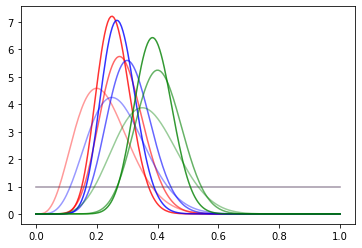

In [22]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

class Beta():
    def __init__(self):
        self.b = 1
        self.a = 1

    def update(self,batch):
        n = len(batch)
        x = sum(batch)
        self.a += x
        self.b += n - x

    def plot(self,color='b',alpha=1):
        span = np.linspace(0,1,200)
        density = beta.pdf(span,self.a,self.b)
        plt.plot(span,density,color=color,alpha=alpha)

mabs = {'m1':{'prob':0.25,
              'array': [1 if i <= 0.25 else 0 for i in np.random.random(100)],
              'machine': Beta(),
              'color':'r'
             },
        'm2':{'prob':0.3,
              'array':[1 if i <= 0.3 else 0 for i in np.random.random(100)],
              'machine': Beta(),
              'color':'b'
             },
        'm3':{'prob':0.26,
              'array':[1 if i <= 0.26 else 0 for i in np.random.random(100)],
              'machine': Beta(),
              'color':'g'
             }
       }

def mab_experiment(betas,prop=0.2):
    size = len(betas['m1']['array'])
    window = int(size*prop)
    batches = [batch for batch in range(0,size,window)]
    print(batches)
    for machine in betas.keys():
        for i in range(1,window):
            try:
                curr = batches[i]
                prev = batches[i-1]
                betas[machine]['machine'].plot(alpha=curr/size,color=betas[machine]['color'])
                batch = betas[machine]['array'][prev:curr]
                betas[machine]['machine'].update(batch)
            except:
                pass
    return betas

betas = mab_experiment(betas=mabs)

In [23]:
mabs['m1']['array'][20:40]

[0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]

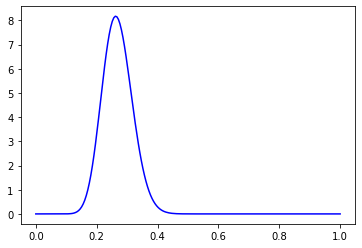

In [26]:
betas['m1']['machine'].plot()